In our project we are extracting tweets which discuss about education policies, their pros and cons. We are extracting tweets based on certain hashtags and do sentiment analysis on the text so to know positive and negative response of that policy. 

In [1]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import twython
from textblob import TextBlob
import json
import pandas as pd
import matplotlib.pyplot as plt
import sys
import re
import dateutil.parser
from pytz import timezone
import pytz
from collections import defaultdict
import urllib
from bs4 import BeautifulSoup
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
#import geography

After importing desired libraries, there are some credentials required to access tweets using twitter APIs, so we have to register our app at their official site to get those credentials.The below few lines of code shows the same.

In [2]:
#Variables that contains the user credentials to access Twitter API 
access_token = "717220472623071233-oeDgXLyYdqT92Mi06aaAGV7EtSExfKS"
access_token_secret = "tVh6WAqVqJ5Pekb3skPON4OD46dyyBAIGOiWjPkZrtglC"
consumer_key = "qiOaRLVPldazXmYmF3IaIQw4L"
consumer_secret = "FAzcCMF1UUyuNuSeddAA1nDJYPeXm6OhaCD084k1t3BZ0HleCY"

In [3]:
#to sync time with twitter server time
sgtz = timezone('Asia/Kolkata')
utc = pytz.timezone('UTC')

In [13]:
#regex = re.compile('|'.join(STATES).lower())
linenum_re = re.compile(r'([A-Z][A-Z]\d+)')
retweets_re = re.compile(r'^RT\s')
url_re = '?P<url>http?://www.[^\s]+'
enc = lambda x: x.encode('latin1', errors='ignore')

The below class searches for all tweets which comes in a stream and load them in json format which is human understandable format.

In [6]:
#This is a basic listener that just prints received tweets to stdout.

class StdOutListener(StreamListener):

    
    def on_data(self, data):
        tweet = json.loads(data)
        tweets_data.append(tweet)
        #print data
        return True
        '''
        # ignore retweets
        #if re.search(retweets_re, text):
        #    return True

        location = enc(tweet['user']['location'])
        source = enc(tweet['source'])
        d = dateutil.parser.parse(enc(tweet['created_at']))

        '''
        
    def on_error(self, status):
        print status



We are filtering tweets based on certain hashtags like #edpolicy,#edreform,#edpolitics for now and storing the json format data in tweets_data list.

In [7]:
if __name__ == '__main__':

    #This handles Twitter authentification and the connection to Twitter Streaming API
    global tweets_data
    tweets_data = []
    l = StdOutListener()
    #l = TweetStreamListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: 'education'
    stream.filter(track=['#edpolicy,#edreform,#edpolitics'])

KeyboardInterrupt: 

The few lines of code below shows the path to Named Entity Recognition directory that add tags to the text which will help in extracting place on which tweet has been made.

In [8]:
stanford_ner_dir = '/home/dell/stanford-ner-2015-04-20/'
eng_model_filename= stanford_ner_dir + 'classifiers/english.all.3class.distsim.crf.ser.gz'
my_path_to_jar= stanford_ner_dir + 'stanford-ner.jar'

st = StanfordNERTagger(model_filename=eng_model_filename, path_to_jar=my_path_to_jar) 

In [10]:
print tweets_data[1]

{u'contributors': None, u'truncated': False, u'text': u'RT @tedfujimoto: Kindergarten: While American Kids Read, Their Finnish Peers Play  https://t.co/j4JHwMEdGm #earlyed #earlyedchat #edpolicy', u'is_quote_status': False, u'in_reply_to_status_id': None, u'id': 863582695049318400, u'favorite_count': 0, u'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', u'retweeted': False, u'coordinates': None, u'timestamp_ms': u'1494729133747', u'entities': {u'user_mentions': [{u'id': 23959413, u'indices': [3, 15], u'id_str': u'23959413', u'screen_name': u'tedfujimoto', u'name': u'Ted Fujimoto'}], u'symbols': [], u'hashtags': [{u'indices': [107, 115], u'text': u'earlyed'}, {u'indices': [116, 128], u'text': u'earlyedchat'}, {u'indices': [129, 138], u'text': u'edpolicy'}], u'urls': [{u'url': u'https://t.co/j4JHwMEdGm', u'indices': [83, 106], u'expanded_url': u'http://www.theatlantic.com/education/archive/2015/10/the-joyful-illiterate-kindergartners-of-finl

In [ ]:
tweets_dict = defaultdict(list)
for tweets in tweets_data:
    if tweets.has_key('user'):
        #print 'No user data - ignoring tweet.'
        user = enc(tweets['user']['name'])
        text = enc(tweets['text'])
        #url = re.search("(?P<url>https?://[^\s]+)", text.lower())
        expanded_url = tweets['entities']['urls']
        #print expanded_url
        if len(expanded_url)!=0 and expanded_url[0]['expanded_url']:
            url = expanded_url[0]['expanded_url']
            content = urllib.urlopen(url).read()
            soup = BeautifulSoup(content)
            tokenized_text = word_tokenize(soup.text)
            classified_text = st.tag(tokenized_text)
            for term,tag in classified_text:
                if tag == 'LOCATION':
                    if term in tweets_dict.keys():
                        tweets_dict[term].append(soup.text)
                    else:
                        tweets_dict[term]=[]
                        tweets_dict[term].append(soup.text)
        
        else:
            tokenized_text = word_tokenize(text)
            classified_text = st.tag(tokenized_text)
            for term,tag in classified_text:
                if tag == 'LOCATION':
                    if term in tweets_dict.keys():
                        tweets_dict[term].append(text)
                    else:
                        tweets_dict[term]=[]
                        tweets_dict[term].append(text)

In [51]:
#print tweets_dict.keys()
for tweets in tweets_data:
    text = enc(tweets["text"])
    expanded_url = tweets['entities']['urls']
    #print expanded_url
    if len(expanded_url)!=0 and expanded_url[0]['expanded_url']:
        url = expanded_url[0]['expanded_url']
    #url = re.search("(?P<url>http?://www.[^\s]+)", tweets["url"])
    #if url:
        content = urllib.urlopen(url).read()
        soup = BeautifulSoup(content)
        print soup.text








Why Kindergarten in Finland Is All About Playtime (and Why That Could Be More Stimulating Than the Common Core) - The Atlantic



































        {
          "@context": "http://schema.org",
          "@type": "Organization",
          "name": "The Atlantic",
          "url": "https://www.theatlantic.com",
          "logo": "https://cdn.theatlantic.com/front/images/logo/213x70.png",
          "sameAs" : [
            "https://www.facebook.com/TheAtlantic",
            "https://twitter.com/theatlantic",
            "https://plus.google.com/109258622984321091629/posts"]
        }
        


        // Chartbeat head
        var _sf_async_config = _sf_async_config || {};
        _sf_async_config.uid = 17396; // ACCOUNT NUMBER
        _sf_async_config.domain = (function() {
            // Paid Facebook traffic will have a UTM code in the form of
            // fbMMDD_VERSION. When this happens, we send traffic to the
            // a different site in Chartbe

In [11]:
positive = defaultdict(list)
negative = defaultdict(list)
neutral = defaultdict(list)
for keys in tweets_dict.keys():
    for tweets in tweets_dict[keys]:
        # pass tweet into TextBlob
        tweet = TextBlob(tweets)

        # output sentiment polarity
        #print keys
        #print tweet.sentiment.polarity

        # determine if sentiment is positive, negative, or neutral
        if tweet.sentiment.polarity < 0:
            #sentiment = "negative"
            if keys in negative.keys():
                negative[keys].append(tweets)
            else:
                negative[keys]=[]
                negative[keys].append(tweets)
        elif tweet.sentiment.polarity == 0:
            #sentiment = "neutral"
            if keys in neutral.keys():
                neutral[keys].append(tweets)
            else:
                neutral[keys]=[]
                neutral[keys].append(tweets)
        else:
            #sentiment = "positive"
            if keys in positive.keys():
                positive[keys].append(tweets)
            else:
                positive[keys]=[]
                positive[keys].append(tweets)
        # output sentiment
        #print sentiment

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 1417: ordinal not in range(128)

In [12]:
print len(positive.keys())
print len(neutral.keys())
print len(negative.keys())

13
18
4


In [13]:
print len(tweets_data)
tweets = pd.DataFrame()

tweets['text'] = map(lambda tweet: tweet['text'], tweets_data)
tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data)


2770


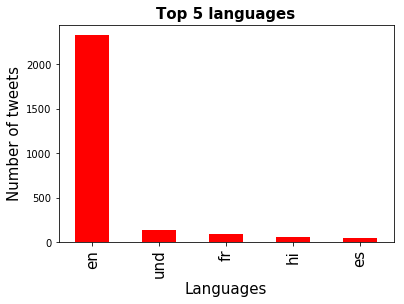

In [14]:
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')
plt.show()

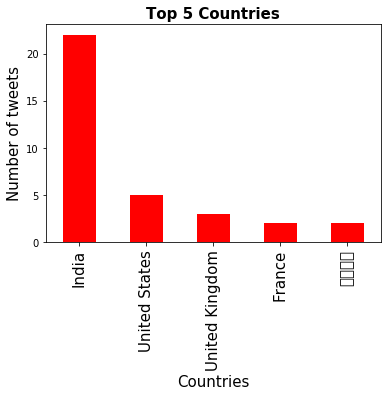

In [19]:
tweets_by_lang = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 Countries', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')
plt.show()